In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

In [2]:
df = pd.read_csv('ChickWeight.csv')

In [3]:
df.shape

(578, 5)

In [4]:
df.head()

,Unnamed: 0,weight,Time,Chick,Diet
0,1,42,0,1,1
1,2,51,2,1,1
2,3,59,4,1,1
3,4,64,6,1,1
4,5,76,8,1,1


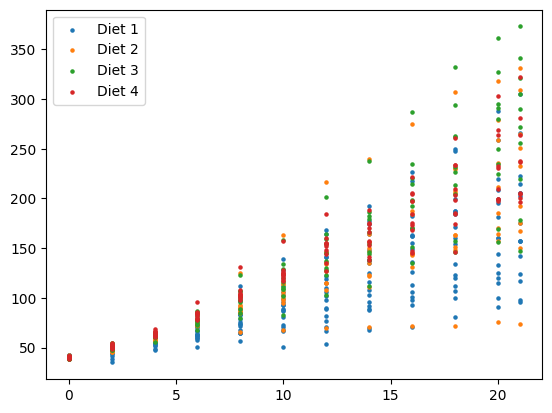

In [5]:
for diet, group in df.groupby('Diet'):
    plt.scatter(group.Time, group.weight, s=5, label=f'Diet {diet}')
plt.legend()
plt.show()

In [6]:
df.groupby('Chick')['Diet'].nunique().max().item()

1

In [7]:
class OnlyEmbeddingLinearRegressionWithIntercept(nn.Module):
    def __init__(self, num_categories):
        super().__init__()
        self.slope_embedding = nn.Embedding(num_embeddings=num_categories + 1, embedding_dim=1)  # Learnable slope per category
        self.bias = nn.Parameter(torch.tensor([0.0]))  # Shared bias for all categories

    def forward(self, x, category):
        slope = self.slope_embedding(category).squeeze(-1)  # Retrieve slope for category
        return x.squeeze(-1) * slope + self.bias  # Apply learned bias

In [8]:
num_categories = 4
model = OnlyEmbeddingLinearRegressionWithIntercept(num_categories)

In [9]:
x = torch.Tensor(df.Time).unsqueeze(-1)
diet = torch.LongTensor(df.Diet)
weight = torch.Tensor(df.weight)

In [10]:
out = model(x, diet)

In [11]:
F.mse_loss(out, weight)

tensor(22001.1875, grad_fn=<MseLossBackward0>)

In [12]:
opt = optim.SGD(params=model.parameters(), lr=1e-2)

In [13]:
for epoch in range(1, 2000 + 1):
    opt.zero_grad()
    out = model(x, diet)
    loss = F.mse_loss(out, weight)
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(f'{epoch} loss={loss}')

100 loss=1209.078125
200 loss=1170.2479248046875
300 loss=1157.57177734375
400 loss=1153.4334716796875
500 loss=1152.0826416015625
600 loss=1151.6416015625
700 loss=1151.4976806640625
800 loss=1151.45068359375
900 loss=1151.4351806640625
1000 loss=1151.4302978515625
1100 loss=1151.4285888671875
1200 loss=1151.427978515625
1300 loss=1151.4278564453125
1400 loss=1151.4278564453125
1500 loss=1151.4278564453125
1600 loss=1151.427734375
1700 loss=1151.427734375
1800 loss=1151.4278564453125
1900 loss=1151.427734375
2000 loss=1151.427734375


In [14]:
bias = model.bias.item()

In [15]:
slopes = model.slope_embedding(torch.LongTensor(range(1, 5))).squeeze(-1).detach().tolist()

In [16]:
bias, slopes

(27.85846519470215,
 [7.049185752868652, 8.660394668579102, 10.78750228881836, 9.910623550415039])

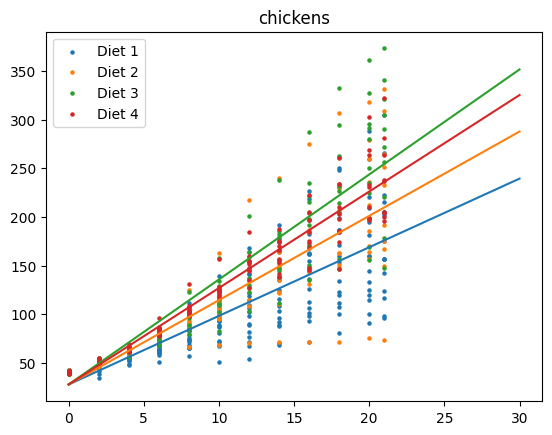

In [17]:
for diet, group in df.groupby('Diet'):
    plt.scatter(group.Time, group.weight, s=5, label=f'Diet {diet}')
    b, s = bias, slopes[diet - 1]
    plt.plot([0, 30], [bias, 30 * s + b]) 
plt.legend()
plt.title('chickens')
plt.show()